# **Problem set 5** - Machine Learning for Physics and Astronomy 2023/2024, UvA

- The total sheet gives 22 points
- Deadline for submitting your results is **Wed, 23/5/2024, 23:59**
- **IMPORTANT**: Specify if/how AI was used to solve the exercises by filling the corresponding "Usage of AI" comments. Anything between "No" (if applicable) and a short paragraph reflecting how AI was used is fine. Failing to do so faithfully will result in the substraction of points.
- **IMPORTANT**: this sheet is to be updated to also cover the material from lectures 10 and 11.

### Remember, if you get the error "No CUDA GPUs are available," go to Runtime > Change runtime type > select GPU.

## Chapter 10: Simulation based inference (22 pt)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

### 1. Measuring Rings (7 pt)

In the last homework session we classified numbers on the MNIST dataset, but this is not representative of the types of tasks that we use neural neutworks for in physics. So we now move on to a different task: measuring the radius of rings produced by a simulator. We define a function that serves as our "simulator," `image_model` which produces images with one or more rings, where the radius, width, and number of rings are simulation parameters.

This model is a toy model for producing simulated images of graviationally lensed systems.  The radius would then correspond to the "Einstein radius" of the [gravitational lensing system](https://en.wikipedia.org/wiki/Einstein_ring) and tell us something about the mass of the lensing galaxy. The width would correspond to the size of the lensed source galaxy.  Normally, you would not get multiple rings in one image, but in our toy model we add this possibility to test just how difficult we can make the problem while still learning the parameters.

As an example, a real strong lensing image looks like this:

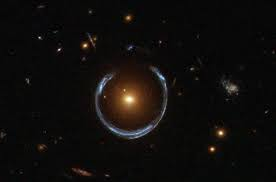

So now we define our "simulator."

In [ ]:
def image_model(radius = 0.5, sigma = 0.3, width = 0.15, n = 1):
    x = np.linspace(-2, 2, 32)
    X, Y = np.meshgrid(x, x)

    # Random position of the ring
    imgs = []
    for i in range(n):
      x0, y0 = np.random.uniform(-1, 1, 2)

      R = ((X-x0)**2 + (Y-y0)**2)**0.5
      img = np.exp(-(R-radius)**2/width**2/2)
      img = img

      imgs.append(img)

    # Standard variance and zero mean
    img = sum(imgs)

    # Remove mean and variance
    img -= img.mean()
    img /= img.std()

    # Add image noise
    img += np.random.randn(*img.shape)*sigma


    return img.reshape(1, 32, 32).astype(np.float32)  # Default CUDA tensors are float32

Next, we next generate our training and test data. In this case, 50000 examples.

In [ ]:
ring_data = []
for i in range(50000):
  r = np.random.rand(1).astype(np.float32)# random float from 0 to 1
  img = image_model(n = 3, radius = r)
  ring_data.append((img, r))

class RingDataset(torch.utils.data.Dataset):
  def __init__(self, ring_data):
    self.ring_data = ring_data

  def __getitem__(self, idx):
    return self.ring_data[idx]

  def __len__(self):
    return len(self.ring_data)

ring_dataset_train = RingDataset(ring_data[:45000])
ring_dataset_test = RingDataset(ring_data[45000:])

We then instantiate the loaders.

In [ ]:
batch_size_train = 64  # by default we use a minibatch size of 64 for training.
# You can leave it like that during the subsequent exercises.

batch_size_test = 64

train_loader = torch.utils.data.DataLoader(ring_dataset_train, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(ring_dataset_test, batch_size=batch_size_test, shuffle=True)

In [ ]:
examples = list(test_loader)
example_data, example_targets = examples[0]

And plot test examples.

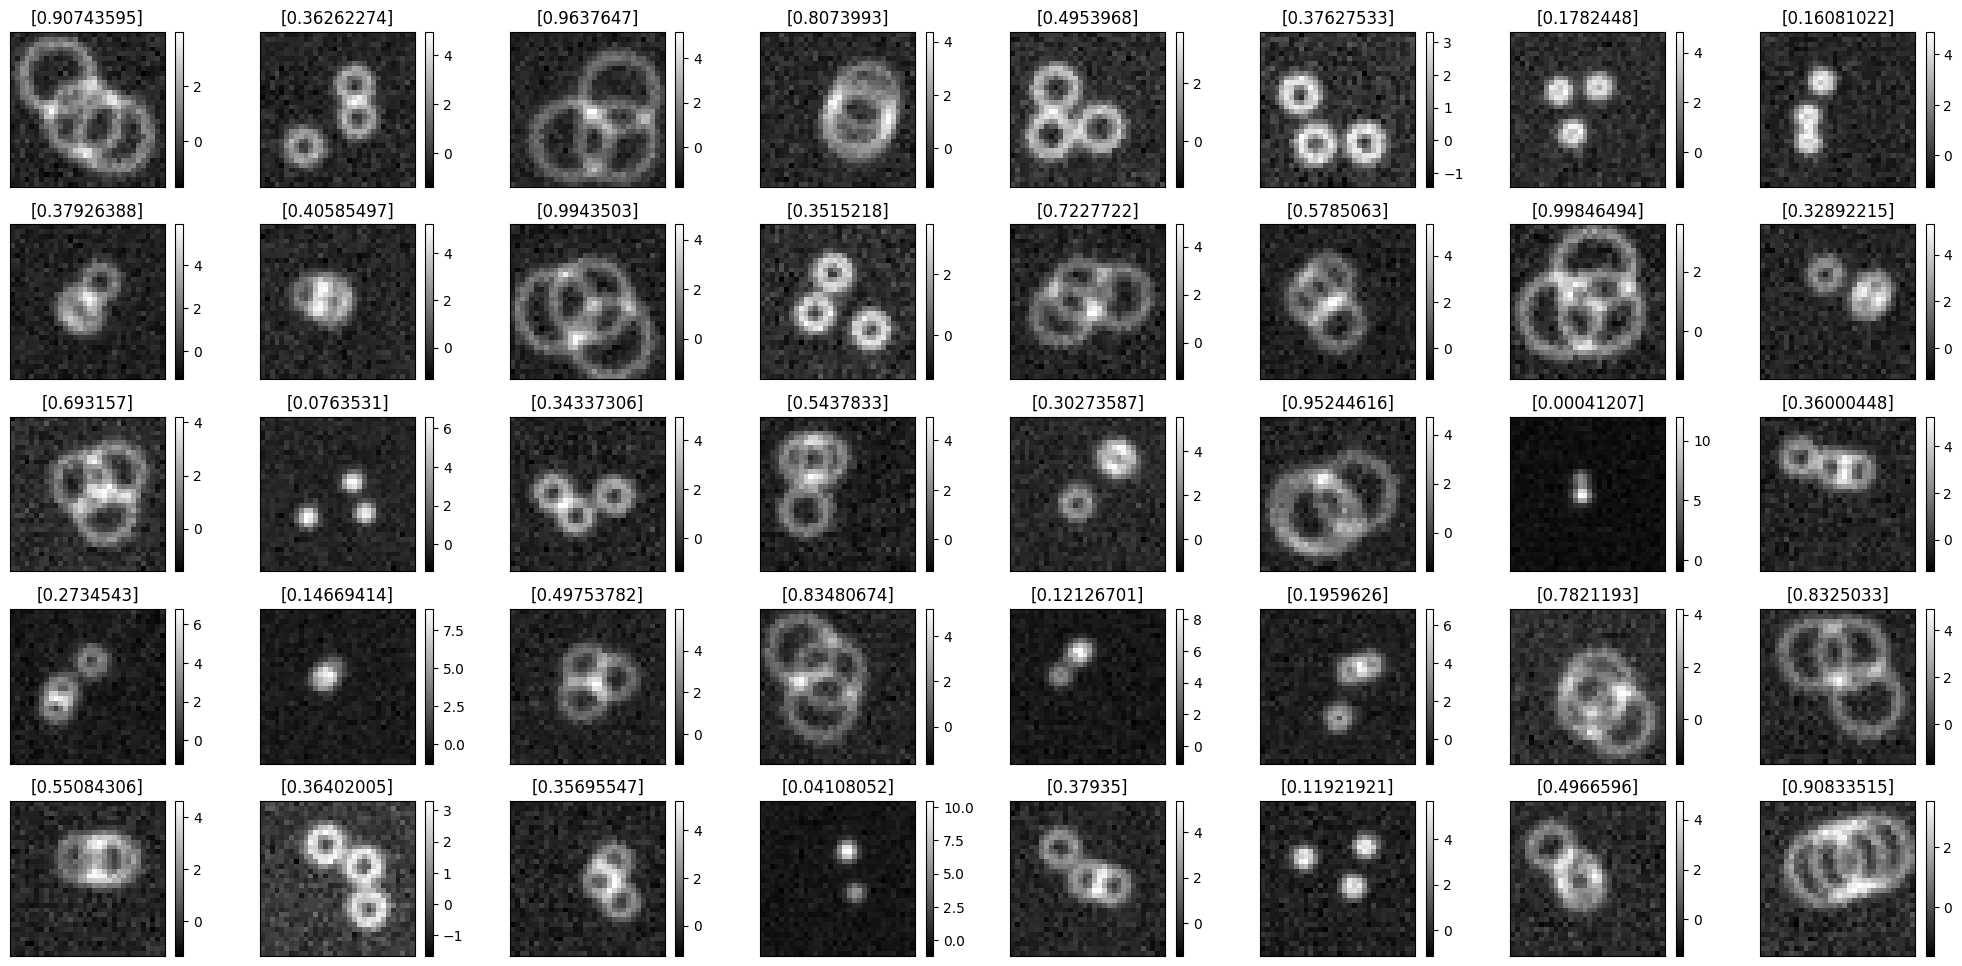

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i in range(40):
  plt.subplot(5,8,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("{}".format(example_targets[i].numpy()))
  plt.xticks([])
  plt.yticks([])
  plt.colorbar()

We first start with a regression-based implementation, where we will train a neural network to predict the radius as a single number directly.

1. Regression model. Create a similar CNN to the one used on the MNIST dataset in the last homework. This time it should predict a single real-valued number that represents the radius. (2pt)

HINTS:
 -  If you did not finish the previous exercise scroll down to see another implementation of a CNN.
 - Always remember to count the in- and ouput dimensions of every layer in your CNN. Both `nn.Conv2d`and `nn.functional.max_pool2d`generally change the output dimensions.

In [ ]:
# Useful imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim




class RegressionCNN(nn.Module):
    def __init__(self):
        super(RegressionCNN, self).__init__()
        # Input size: (batch_size, 1, 32, 32)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)  # Output size: (batch_size, 10, 32, 32)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16, 20, kernel_size=5, padding=2)  # Output size: (batch_size, 20, 32, 32)
        self.fc1 = nn.Linear(20 * 8 * 8, 50)  # Adjusted for the new flattened size after pooling
        self.fc2 = nn.Linear(50, 1)  # Output size: (batch_size, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # Output size: (batch_size, 10, 16, 16) after pooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # Output size: (batch_size, 20, 8, 8) after pooling
        # Flatten the tensor to (batch_size, 20*8*8)
        x = x.view(-1, 20 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.view(-1)  # Flatten the batch of outputs to a batch of scalars

# Initialize the model
model = RegressionCNN()



2. Before, we were doing classification and so we used the appropriate cross-entropy loss. Now, we must replace the loss with mean square error (MSE) for regression. Define the training loop below with this new loss function. (1pt)

In [ ]:
train_loader

In [ ]:
def train(epoch):
    model.train()  # Set the model to training mode
    log_interval = 100  # Define the log_interval
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to the same device as the model
        data, target = data.to(device), target.to(device).float()  # Ensure target is float

        # calculate forward step
        output = model(data)  # Forward pass: compute the output class given an image
        loss = criterion(output, target.view(-1))  # Calculate the loss; ensure target is 1D

        # calculate Backward step
        optimizer.zero_grad()  # Clear the gradients of all optimized tensors
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)

        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')



3. Train the network on GPU. If everything works, you should see that the loss decreases. (Refer to previous exercises if you need guidance.) (2pt)

Hint: If your network doesn't train, try using a smaller learning rate (e.g. 0.001).

In [ ]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

# Move the model to the chosen device
model = RegressionCNN().to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Perform training
for epoch in range(1, 3):  # Adjust the number of epochs as needed
    train(epoch)

Training on device: cpu
Train Epoch: 1 [0/45000 (0%)]	Loss: 0.414011
Train Epoch: 1 [6400/45000 (14%)]	Loss: 0.024813
Train Epoch: 1 [12800/45000 (28%)]	Loss: 0.009509
Train Epoch: 1 [19200/45000 (43%)]	Loss: 0.008545
Train Epoch: 1 [25600/45000 (57%)]	Loss: 0.010049
Train Epoch: 1 [32000/45000 (71%)]	Loss: 0.007280
Train Epoch: 1 [38400/45000 (85%)]	Loss: 0.008793
Train Epoch: 1 [44800/45000 (99%)]	Loss: 0.005212
Train Epoch: 2 [0/45000 (0%)]	Loss: 0.005631
Train Epoch: 2 [6400/45000 (14%)]	Loss: 0.005965
Train Epoch: 2 [12800/45000 (28%)]	Loss: 0.007123
Train Epoch: 2 [19200/45000 (43%)]	Loss: 0.008311
Train Epoch: 2 [25600/45000 (57%)]	Loss: 0.004022
Train Epoch: 2 [32000/45000 (71%)]	Loss: 0.003874
Train Epoch: 2 [38400/45000 (85%)]	Loss: 0.006357
Train Epoch: 2 [44800/45000 (99%)]	Loss: 0.004656


4. Illustrate the reconstruction quality by running 1000 test images through the network and recording the outputs.  Show correct (x-axis) vs reconstructed (y-axis) radii in a scatter plot (`plt.scatter`). How well does your network perform? (1pt)

In [ ]:
test_loader

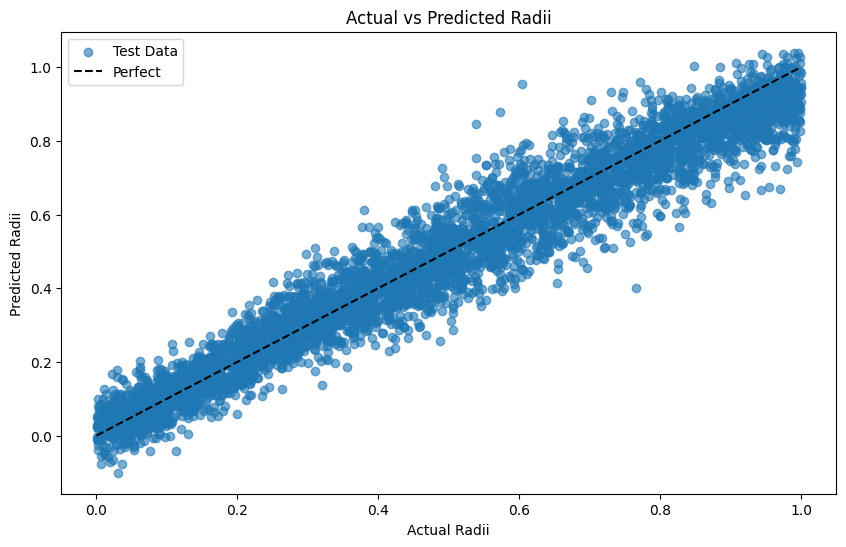

In [ ]:
# Ensure the model is in evaluation mode, which turns off dropout.
model.eval()

# Run the model on the test set and collect the actual and predicted radii.
actual_radii = []
predicted_radii = []

with torch.no_grad():  # Turn off gradients for validation, saves memory and computations.
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        predicted_radii.extend(output.view(-1).cpu().numpy())  # Convert to numpy array after moving to cpu.
        actual_radii.extend(target.view(-1).cpu().numpy())

# Create the scatter plot.
plt.figure(figsize=(10, 6))
plt.scatter(actual_radii, predicted_radii, alpha=0.6, label='Test Data')
plt.xlabel('Actual Radii')
plt.ylabel('Predicted Radii')
plt.title('Actual vs Predicted Radii')
# Add a diagonal line to show where the points would lie if the predictions were perfect.
plt.plot([min(actual_radii), max(actual_radii)], [min(actual_radii), max(actual_radii)], 'k--', label='Perfect')
plt.legend()



I think my CNN network performs reasonably well! it looks like a line with a bit of width!, I think its about centered on the dashed line indicating little systemic over or under estimating (depending on how many epochs I train over)

5. Imagine your are provided with a single image, and you have to use your network to estimate the radius of the rings and quote your best estimate together with error bars. Write 2-3 qualitative sentences about how you could obtain this error bar from the plot that you generated in the previous point. (1pt)

From my plot:

I can make a plot of the residuals, (model-true), or the normalization version (model-true)/true.

 This now tells me the relative closeness of the prediction vs the true value. I can then google how to do the STD calculation, something something at lvl B, a certain % of the predictions are within % of being correct.

 and use that to estimate my errors. IE std = 3-10% or something like that.

**Usage** of AI: *COMMENT HERE*

### 2. Simulation-based inference of posteriors (11 pt)

In the previous exercise, we predicted a single value for the radius, but this did not tell us anything about the probability of the predicted value. In this exercise, we will use the neural likelihood-free based inference method (focusing on neural ratio estimation) discussed in class to obtain proper Bayesian posteriors for the radius, instead of just a point estimator.

Let's start by defining a neural network that takes as input both an image $x$ as well as a label (in our case radius) $z$.  The output will be the probability that $x$ and $z$ are jointly drawn, $x, z \sim p(x, z)$, rather than marginally, $x, z \sim p(x)p(z)$.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim  as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(501, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x, z):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 500)
        x = torch.cat((x, z), axis = 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

1. What does the `torch.cat` function do in this context? Relate it back to the math dicussed in class.  (1 pt)

In the provided code, the torch.cat function is used to concatenate two tensors along a specified dimension. The function signature is torch.cat(tensors, dim=0, out=None), where tensors is a sequence of tensors to concatenate, dim is the dimension along which to concatenate them, and out is the output tensor.

In this context, torch.cat((x, z), axis=1) concatenates the tensor x, which represents the output from the preceding layers of the network (after being reshaped to a 2D tensor with -1 implying an inferred dimension and 500 being the flattened features from the convolutions), with the tensor z, which contains the additional input data (in this case, the radius label).

Relating this to the math discussed in class, the concatenation operation is a way to integrate auxiliary information (the label z) with the features extracted from the image x. By concatenating x and z, we are effectively creating a joint representation that combines both the image features and the label information. This joint representation is then passed through subsequent layers of the neural network.

In probabilistic terms, this can be seen as an attempt to model the joint probability distribution $p(x, z)$, as the network learns a representation that captures the dependencies between the image data and the labels, rather than treating them independently which would correspond to the marginal distributions $p(x)$ and $p(z)$. The final output of the network is a probability score indicating how likely it is that the input image $x$ and the label $radius$ $z$ are jointly drawn from the joint distribution $p(x, z)$.$.

Now we define the optimizer, and instantiate the network.

In [ ]:
learning_rate = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network = Net().to(DEVICE)  # We move the network to the GPU
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

By default, we will use `n_epochs = 3` throughout.  Leave it like that.

In [ ]:
n_epochs = 3  # 3 epochs by default.

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

The main training loop is now given as follows.

In [ ]:
log_interval = 10

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data = data.to(DEVICE)
    target = target.to(DEVICE)

    output_joined = network(data[1:], target[1:])
    output_marginal = network(data[1:], torch.rand_like(target[1:]))

    loss = -torch.log(output_joined) - torch.log(1-output_marginal)
    loss = loss.sum()

    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

2. Explain the role of the two different `output` variables, and how those enter the binary cross-entropy loss function. Write down the mathematical definition of the loss function that we implement (in terms of an integral). (1 pt)

In the given training function, two different outputs are computed using the network: output_joined and output_marginal. These two outputs play distinct roles in constructing a loss that encourages the network to differentiate between joint and marginal distributions of the data and the labels.

output_joined is the output of the neural network when it is given the actual target labels associated with the input data. It represents the probability that the given pair of image and label (data, target) are drawn from the joint distribution $p(x, z)$. This means the network is evaluating how likely it is that the image and the label occur together naturally.

output_marginal is the output of the neural network when it is given random labels (generated by torch.rand_like(target[1:])) instead of the actual target labels. It represents the probability that the given image and a random label are drawn from the joint distribution $p(x, z)$. This should ideally be low since the random labels do not have a natural correspondence with the images.

The loss function used here is derived from the binary cross-entropy loss, which for a single sample is defined as: $$ (y \cdot \log(p) + (1 - y) \cdot \log(1 - p)) $$ where $y$ is the true label (0 or 1) and $p$ is the predicted probability.
In the context of the training function, the loss is computed as: $$ \sum (\log(\text{output_joined}) + \log(1 - \text{output_marginal})) $$
This is essentially summing the binary cross-entropy loss over all samples in the batch, where for output_joined the true label is 1 (since we want a high probability for the true image-label pair), and for output_marginal the true label is 0 (since we want a low probability for the image-random label pair).

The integral form of the loss function, assuming a continuous distribution, would be:


$$\int [ \log(p(x, z)) + \log(1 - p(x, z')) ] dx dz $$

where $p(x, z)$ is the model's estimate of the joint probability for the true label $z$, and $p(x, z')$ is the model's estimate of the joint probability for a randomly sampled label $z'$. The integral goes over the whole data space of images $x$ and labels $z$.

In practice, since we are working with discrete batches of data, the integral is approximated by the sum over all samples in the batch, which is what the loss computation in the code reflects. The loss.sum() operation performs this summation.

Finally, the loss function is backpropagated (loss.backward()) to update the weights of the neural network, and the optimizer step (optimizer.step()) applies the updates. The goal is to minimize this loss over training, which would mean the network is effectively distinguishing between joint and marginal distributions of images and labels..

In [ ]:
for epoch in range(1, n_epochs + 1):
  train(epoch)

Train Epoch: 1 [0/45000 (0%)]	Loss: 0.003986
Train Epoch: 1 [6400/45000 (14%)]	Loss: 0.004892
Train Epoch: 1 [12800/45000 (28%)]	Loss: 0.004662
Train Epoch: 1 [19200/45000 (43%)]	Loss: 0.004190
Train Epoch: 1 [25600/45000 (57%)]	Loss: 0.004242
Train Epoch: 1 [32000/45000 (71%)]	Loss: 0.003903
Train Epoch: 1 [38400/45000 (85%)]	Loss: 0.005552
Train Epoch: 1 [44800/45000 (99%)]	Loss: 0.003643
Train Epoch: 2 [0/45000 (0%)]	Loss: 0.005441
Train Epoch: 2 [6400/45000 (14%)]	Loss: 0.006026
Train Epoch: 2 [12800/45000 (28%)]	Loss: 0.004102
Train Epoch: 2 [19200/45000 (43%)]	Loss: 0.004891
Train Epoch: 2 [25600/45000 (57%)]	Loss: 0.006945
Train Epoch: 2 [32000/45000 (71%)]	Loss: 0.003682
Train Epoch: 2 [38400/45000 (85%)]	Loss: 0.005236
Train Epoch: 2 [44800/45000 (99%)]	Loss: 0.004921
Train Epoch: 3 [0/45000 (0%)]	Loss: 0.004432
Train Epoch: 3 [6400/45000 (14%)]	Loss: 0.006126
Train Epoch: 3 [12800/45000 (28%)]	Loss: 0.003962
Train Epoch: 3 [19200/45000 (43%)]	Loss: 0.004919
Train Epoch: 3 [25

3. Write some code to plot, for a given image, the posterior of the radius. To this end, the network should be evaluated for the same $x$ and for a continuous range of $z$'s (i.e. radii).  Plot the posterior for 10 different images, together with the true values as a vertical line (`plt.axvline`). Hint: check how the data were generated to remind yourself of the allowed radii in our synthetic dataset. Make sure to correctly normalize the posterior to one (neural ratio estimation provides posteriors that are only approximately normalized to one). (3 pt)

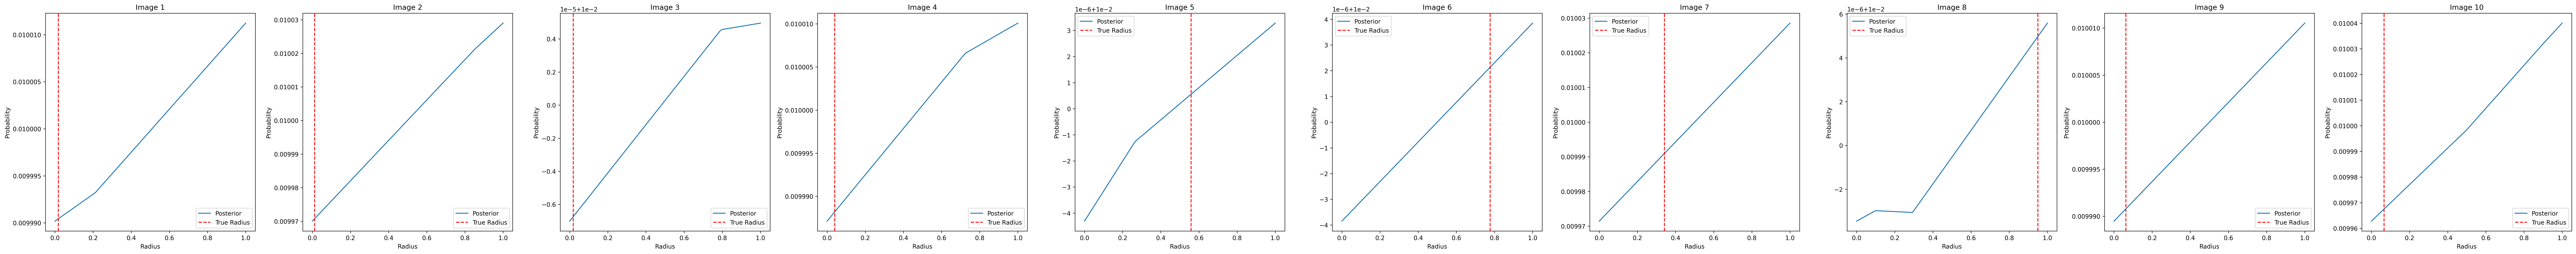

In [ ]:
def plot_posterior(net, device, data_loader, num_images=10):
    # Assume radii can range from 0 to 1, adjust this range if different
    radii = np.linspace(0, 1, 100)
    net.eval()  # Set the network to evaluation mode

    fig, axes = plt.subplots(1, num_images, figsize=(6*10, 6), dpi=300)

    with torch.no_grad():  # No need to track gradients
        for i, (images, true_radii) in enumerate(data_loader):
            if i >= num_images:  # We only plot for the first num_images
                break

            image = images[i].to(device)
            image = image.unsqueeze(0)  # Add batch dimension
            true_radius = true_radii[i].item()

            posteriors = []

            for radius in radii:
                z = torch.tensor([[radius]], device=device, dtype=torch.float32)
                posterior = net(image, z).item()
                posteriors.append(posterior)

            # Normalize the posterior so that it sums to one
            posteriors = np.array(posteriors)
            posteriors /= np.sum(posteriors)

            # Plot the posterior and the true radius
            ax = axes[i]
            ax.plot(radii, posteriors, label='Posterior')
            ax.axvline(x=true_radius, color='r', linestyle='--', label='True Radius')
            ax.set_title(f'Image {i+1}')
            ax.set_xlabel('Radius')
            ax.set_ylabel('Probability')
            ax.legend()

    plt.tight_layout()
    plt.show()

# Use this function to plot the posterior for 10 different images
plot_posterior(network, DEVICE, train_loader)

4. For each image in the test dataset, derive a posterior and then the boundaries of the 68% credible interval (highest posterior density interval). Next, since our test dataset contains 1000 examples, calculate the fraction of the test examples where the true value lies within the 68% containment interval of the posterior predicted by the neural network. Report this value. Lastly, visualize this by plotting, for each example in the test dataset, a black vertical line representing the containment interval on a plot where the x_axis indicates the true values of the radius and the y-axis represens the NN-predicted values. (3pts)

Hint: your plot should look something like this in the end:

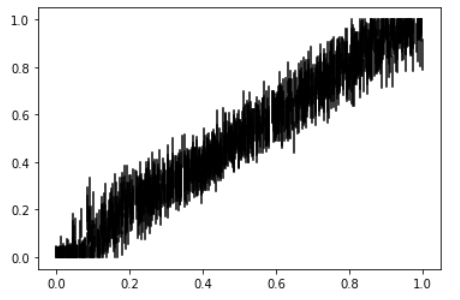

Fraction of true values within the 68% credible interval: 0.0008


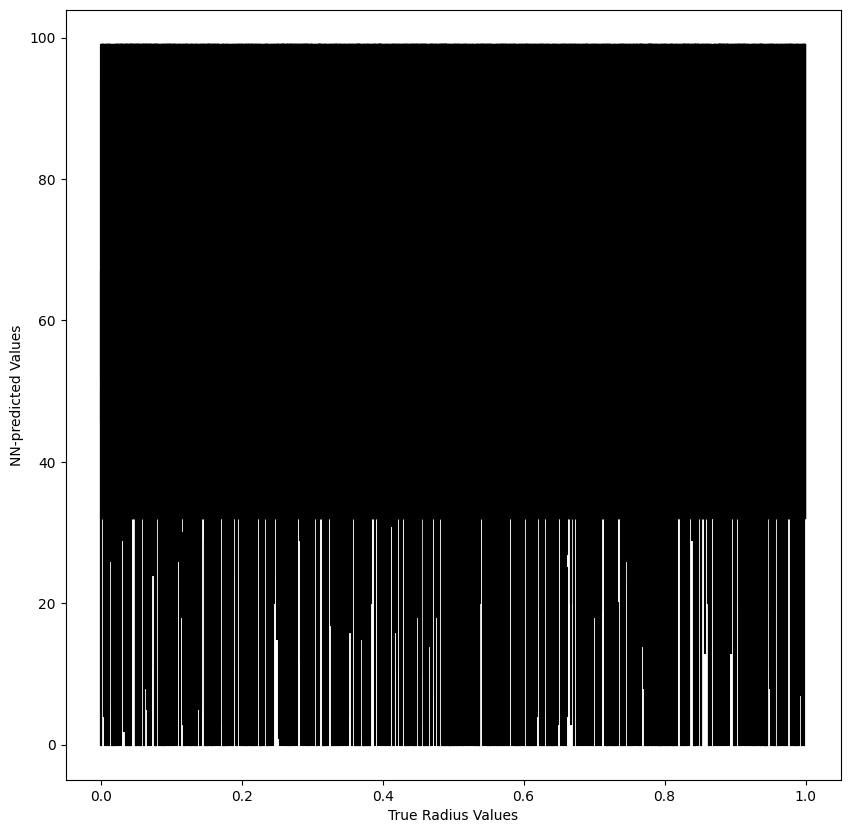

In [ ]:

def compute_credible_interval(posterior, confidence_level):
    # This function computes the highest posterior density interval
    # for a given posterior distribution and confidence level
    sorted_indices = np.argsort(posterior)
    sorted_posterior = posterior[sorted_indices]
    ci_index = int(confidence_level * len(sorted_posterior))
    interval = sorted_posterior[-ci_index:]
    min_value = sorted_indices[-ci_index]
    max_value = sorted_indices[-1]
    return min_value, max_value

def visualize_credible_intervals(credible_intervals):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 10))
    for ci_lower, ci_upper, true_value in credible_intervals:
        plt.plot([true_value, true_value], [ci_lower, ci_upper], 'k')
    plt.xlabel('True Radius Values')
    plt.ylabel('NN-predicted Values')


def test():
    network.eval()
    correct = 0
    total = 0
    posteriors = []

    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(DEVICE)
            target = target.to(DEVICE)
            # Here we need to sample a range of z values to find the posterior
            z_samples = torch.linspace(0, 1, steps=100)  # Adjust the range and steps according to your problem
            z_samples = z_samples.to(DEVICE)
            posteriors_batch = []

            for z in z_samples:
                z_batch = z.repeat(len(data), 1)
                output = network(data, z_batch)
                posteriors_batch.append(output)

            posteriors_batch = torch.stack(posteriors_batch, dim=1).squeeze()
            posteriors.append(posteriors_batch.cpu().numpy())
            # You can now calculate the 68% credible interval for each example here or after collecting all posteriors

    # Calculate the fraction of true values within the 68% credible intervals
    credible_intervals = []
    for i, (posterior, (data, target)) in enumerate(zip(posteriors, test_loader)):
        target = target.numpy()
        for j in range(len(data)):
            # Compute the 68% credible interval from the posterior
            ci_lower, ci_upper = compute_credible_interval(posterior[j], 0.68)
            credible_intervals.append((ci_lower, ci_upper, target[j]))
            if ci_lower <= target[j] <= ci_upper:
                correct += 1
            total += 1

    # Calculate the fraction of correct intervals
    fraction_correct = correct / total
    print(f"Fraction of true values within the 68% credible interval: {fraction_correct}")

    # Visualization
    visualize_credible_intervals(credible_intervals)

test()

5. Repeat part of the previous exercise for 95% and 99% credible intervals and estimate the fraction of training data examples where the true value is contained in the credible interval (no visualization like in the previous exercise required).  Discuss whether your posterior estimation is conservative or overconfident (3 pt).


In [ ]:
from google.colab import files
files.download('colab_requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('colab_requirements.txt')

absl-py==1.4.0
aiohttp==3.9.5
aiosignal==1.3.1
alabaster==0.7.16
albumentations==1.3.1
altair==4.2.2
annotated-types==0.6.0
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==23.2.0
audioread==3.0.1
autograd==1.6.2
Babel==2.15.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.23.1
bigframes==1.5.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.4
bqplot==0.12.43
branca==0.7.2
build==1.2.1
CacheControl==0.14.0
cachetools==5.3.3
catalogue==2.0.10
certifi==2024.2.2
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.86
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpathlib==0.16.0
cloudpickle==2.2.1
cmake==3.27.9
cmdstanpy==1.2.2
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.4
cons==0.4.6
contextlib2==21.6.0
contourpy==1.2.1
cryptography==42.0.7
cuda-python==12.2.1
cudf-cu12 @ https:

In [ ]:
## your code herea

YOUR ANSWER HERE

**Usage** of AI: *COMMENT HERE*

### 3. Loss function gymnastics (4 pt)

1. (2 points) The loss function for neural ratio estimation is given by
$$
L=-\mathbb{E}_{x, z \sim p(x, z)}\left[\ln \sigma\left(f_\theta(x, z)\right)\right]-\mathbb{E}_{x, z \sim p(x) p(z)}\left[\ln \sigma\left(-f_\theta(x, z)\right)\right] .
$$

We claimed in the lecture that minimizing the loss will lead to a $f_\theta(x, z) \approx \ln r(x, z)$, with the likelihood-to-evidence ratio $r(x, z) \equiv \frac{p(x, z)}{p(x) p(z)}$. Show that minimizing the loss w.r.t. $\theta$ indeed yields $\ln r(x, z)$. Explain all steps of your calculation.

YOUR ANSWER HERE

2. (2 points) After warming up with the NRE loss, now consider the bivariate probability distribution $p(x, y)$ and the loss function
$$
L\left[M_\phi\right]=\int d x d y p(x, y)\left(x-M_\phi(y)\right)^2,
$$
where $M_\phi(y)$ denotes a flexible neural network with 1-dim input and 1-dim output, parametrized through the parameters $\phi$.

Minimize the loss w.r.t. $\phi$ and derive the $M_\phi(y)$  that minimizes $L$.

YOUR ANSWER HERE

**Usage** of AI: *COMMENT HERE*